In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import math
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    # 'text.usetex': True
})

In [3]:
def extract_information(file_path):
    """
    Extracts the implementation type (CPU or GPU), the argument value from the filename,
    and the execution time from the content of the file.
    """
    # Extract implementation and number of docs from filename
    parts = file_path.stem.split('-')  # split the stem part of the filename
    implementation = parts[1].upper()  # Get 'CUDA' or 'CPU' and make it uppercase
    _, implementation, n_docs, n_queries, iteration = parts
    implementation = 'CPU' if implementation.upper()=='CPU' else 'CUDA'
    iteration = int(iteration)
    n_docs = int(n_docs)
    n_queries = int(n_queries)
    
    # Read execution time from file
    execution_time = float('inf')
    with file_path.open('r') as file:
        for line in file:
            if "Elapsed time:" in line:
                execution_time = float(line.split()[-2])  # Get the last second to last part assuming "Elapsed time: X ms"
                break
    if execution_time is None:
        print(f"Failed to parse execution time in {file_path}")
        return None
    return dict(implementation=implementation, n_docs=n_docs, n_queries=n_queries, execution_time=execution_time, iteration=iteration)

In [4]:
# Collect all txt files matching the pattern
files = Path('../tmp/results/').glob('out-*.txt')

# Extract information from each file and create a DataFrame
data = [item for item in [extract_information(file) for file in files] if item]
df = pd.DataFrame.from_records(data)
df.head()

,implementation,n_docs,n_queries,execution_time,iteration
0,CUDA,1000,100,236.462,6
1,CUDA,100,50,227.760,6
2,CUDA,100,100,222.600,3
3,CPU,100,10,10.062,5
4,CPU,10000,10,530.936,2


In [5]:
agg_df = (
    df[['implementation', 'n_docs', 'n_queries', 'execution_time']]
        .groupby(['implementation', 'n_docs', 'n_queries'])
        .agg(['median', 'mean', 'min', 'max', 'std'])
        .reset_index()
        .sort_values(by=['implementation', 'n_docs', 'n_queries'])
)
agg_df.columns = [f'{col[1]}_{col[0]}' if col[0] == 'execution_time' else col[0] for col in agg_df.columns]
agg_df['throughput'] = agg_df['n_queries'].values/(agg_df['median_execution_time'].values/1000)
agg_df.head()

,implementation,n_docs,n_queries,median_execution_time,mean_execution_time,min_execution_time,max_execution_time,std_execution_time,throughput
0,CPU,10,10,1.2130,1.0531,0.532,1.278,0.290980,8244.023083
1,CPU,10,50,5.3955,5.2401,4.289,5.952,0.615746,9266.981744
2,CPU,10,100,8.9350,8.8677,5.274,10.215,1.373675,11191.941802
3,CPU,100,10,9.3545,7.9608,5.161,10.062,2.306870,1069.004223
4,CPU,100,50,39.8070,39.8189,38.791,41.051,0.812755,1256.060492


In [6]:
cpu_mask = agg_df['implementation']=='CPU'
gpu_mask = agg_df['implementation']=='CUDA'

### Execution time vs number of docs

In [7]:
def plot_execution_time_vs_n_docs(agg_df, n_queries: int):
    q_mask = agg_df['n_queries']==n_queries

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.scatter(agg_df.loc[cpu_mask & q_mask, 'n_docs'], agg_df.loc[cpu_mask & q_mask, 'median_execution_time'], label='CPU', marker='.', s=100, c='red')

    ax.scatter(agg_df.loc[gpu_mask & q_mask, 'n_docs'], agg_df.loc[gpu_mask & q_mask, 'median_execution_time'], label='CUDA', marker='.', s=100, c='blue')

    ax.set_title(f'Q={n_queries}')
    ax.set_ylabel('Time (ms)')
    ax.set_xlabel('Number of documents')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend(loc='best')
    plt.tight_layout()

    return fig

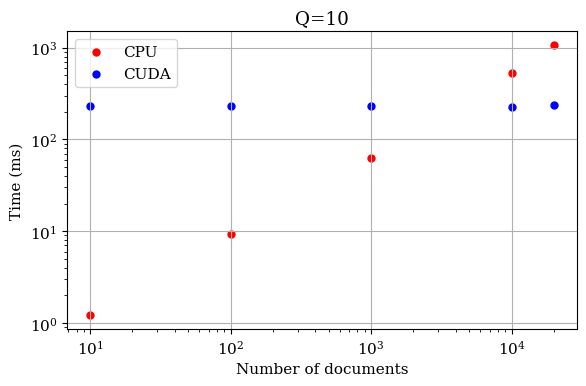

In [8]:
n_queries = 10
fig = plot_execution_time_vs_n_docs(agg_df, n_queries);
fig.savefig(f'figures/execution-time-vs-n-docs-q{n_queries}.png', dpi=300)

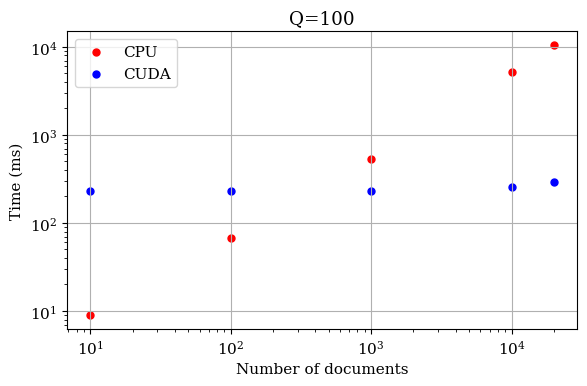

In [9]:
n_queries = 100
fig = plot_execution_time_vs_n_docs(agg_df, n_queries);
fig.savefig(f'figures/execution-time-vs-n-docs-q{n_queries}.png', dpi=300)

### Throughput vs number of docs

In [10]:
def plot_throughput_vs_n_docs(agg_df, n_queries):
    mask = agg_df['n_queries']==n_queries
    # mask = np.ones(len(agg_df))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.scatter(agg_df.loc[cpu_mask&mask, 'n_docs'], agg_df.loc[cpu_mask&mask, 'throughput']+1e-3, label='CPU', marker='.', s=100, c='red')

    ax.scatter(agg_df.loc[gpu_mask&mask, 'n_docs'], agg_df.loc[gpu_mask&mask, 'throughput'], label='CUDA', marker='.', s=100, c='blue')

    ax.set_title(f'Q={n_queries}')
    ax.set_ylabel('Throughput (query / second)')
    ax.set_xlabel('Number of documents')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend(loc='best')
    plt.tight_layout()

    return fig

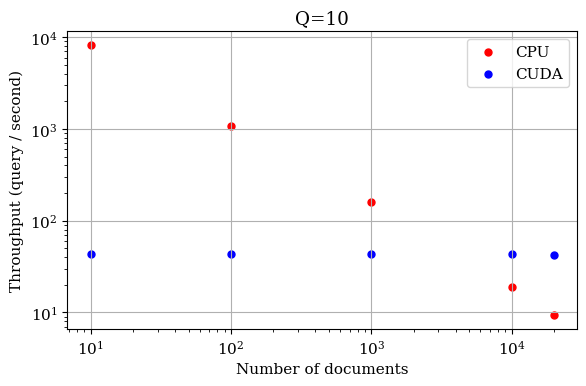

In [11]:
n_queries=10
fig = plot_throughput_vs_n_docs(agg_df, n_queries=n_queries);
fig.savefig(f'figures/throughput-vs-n-docs-q{n_queries}.png', dpi=300)

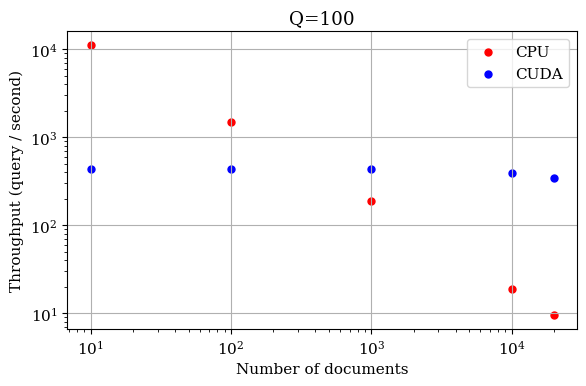

In [12]:
n_queries=100
fig = plot_throughput_vs_n_docs(agg_df, n_queries=n_queries);
fig.savefig(f'figures/throughput-vs-n-docs-q{n_queries}.png', dpi=300)

### Throughput vs number of queries

In [13]:
def plot_throughput_vs_n_queries(agg_df, n_docs=1000):
    mask = agg_df['n_docs']==n_docs
    # mask = np.ones(len(agg_df))

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.scatter(agg_df.loc[cpu_mask&mask, 'n_queries'], agg_df.loc[cpu_mask&mask, 'throughput']+1e-3, label='CPU', marker='.', s=100, c='red')

    ax.scatter(agg_df.loc[gpu_mask&mask, 'n_queries'], agg_df.loc[gpu_mask&mask, 'throughput'], label='CUDA', marker='.', s=100, c='blue')

    ax.set_title(f'N={n_docs}')
    ax.set_ylabel('Throughput (query / second)')
    ax.set_xlabel('Number of queries')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend(loc='best')
    plt.tight_layout()

    return fig

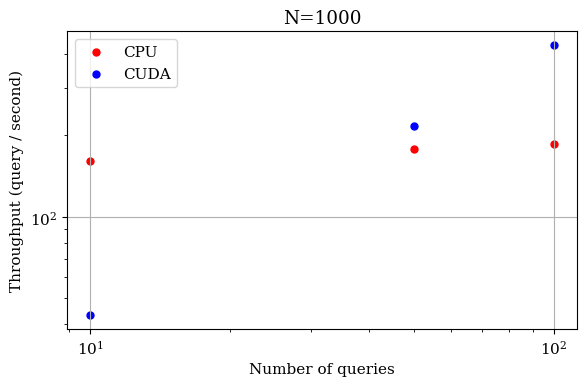

In [14]:
n_docs=1000
fig = plot_throughput_vs_n_queries(agg_df, n_docs);
fig.savefig(f'figures/throughput-vs-n-queries-n{n_docs}.png', dpi=300)

## Execution time vs number of queries

In [15]:
def plot_execution_time_per_n_queries(agg_df, n_docs: int):
    d_mask = agg_df['n_docs']==n_docs

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.scatter(agg_df.loc[cpu_mask & d_mask, 'n_queries'], agg_df.loc[cpu_mask & d_mask, 'median_execution_time'], label='CPU', marker='.', s=100, c='red')

    # print(len(agg_df.loc[cpu_mask & d_mask, 'n_queries']))
    ax.scatter(agg_df.loc[gpu_mask & d_mask, 'n_queries'], agg_df.loc[gpu_mask & d_mask, 'median_execution_time'], label='CUDA', marker='.', s=100, c='blue')

    ax.set_title(f'N={n_docs}')
    ax.set_ylabel('Time (ms)')
    ax.set_xlabel('Number of queries')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend(loc='best')
    plt.tight_layout()

    return fig

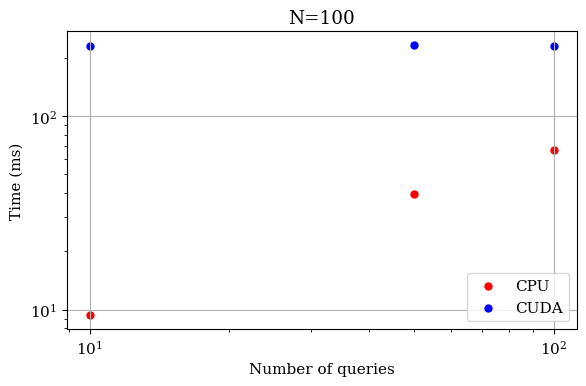

In [16]:
n_docs=100
fig = plot_execution_time_per_n_queries(agg_df, n_docs);
fig.savefig(f'figures/execution-time-vs-n-queries-n{n_docs}.png', dpi=300)

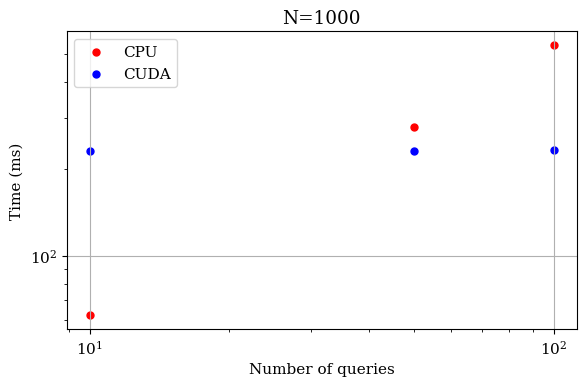

In [17]:
n_docs=1000
fig = plot_execution_time_per_n_queries(agg_df, n_docs);
fig.savefig(f'figures/execution-time-vs-n-queries-n{n_docs}.png', dpi=300)